# Importing packages and load CNN

In [2]:
import pykat
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pykat.optics.gaussian_beams as gb
import keras
from keras import backend as k
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import tensorflow as tf
import pickle
from copy import deepcopy
from tqdm import tqdm
import time
import os

# Telling the notebook to make plots inline.
%matplotlib inline  

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=12)

n_pixl = 128
tilt_step = 1e-4
SaveModelFolder = '/home/user1/Dropbox/Academic/WORK/Beam_auto_alignment/Data/TrainedModels/'
Model_Name = 'Trained_Model_2019-07-03_17-15'

# # Read the pre-trained CNN model
# cnn = keras.models.load_model(SaveModelFolder + Model_Name + '.h5')
# # load the encoder
# loaded_Encoder = pickle.load(open(SaveModelFolder + 'Encoder_of_' + Model_Name + '.npy', 'rb'))

                                              ..-
    PyKat 1.1.331         _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



Using TensorFlow backend.


## Define Functions

In [2]:
def check_direction(old_mode, new_mode, xDir, yDir):
    if int(old_mode[-3]) < int(new_mode[-3]):
        xDir = not xDir
        print("X direction reversed")
    if int(old_mode[-1]) < int(new_mode[-1]):
        yDir = not yDir
        print("Y direction reversed")
    return xDir, yDir

def get_steps(Mode, Dir, c1, c2):
    if Mode > 0:
        if Dir:
            c1 += tilt_step
            c2 += tilt_step
        if not Dir:
            c1 -= tilt_step
            c2 -= tilt_step
    return c1, c2

def steering_inp(mode, xDir, yDir, x1, x2, y1, y2):
    # X mode
    x1, x2 = get_steps(int(mode[-3]), xDir, x1, x2)
    # Y mode
    y1, y2 = get_steps(int(mode[-1]), yDir, y1, y2)
    return x1, x2, y1, y2

def read_mode(out):
    # Captured image
    Img = np.array(out['CCD'])
    Img += np.random.random(Img.size).reshape(Img.shape)
    Img /= np.max(Img)
    Img = 1. - Img
    plt.imshow(Img[::-1], cmap=cm.binary)
    plt.colorbar()
    plt.show()
    mode = cnn.predict(Img[::-1].reshape(1,n_pixl,n_pixl,1))
    probs = cnn.predict_proba(Img[::-1].reshape(1,n_pixl,n_pixl,1))
    print(probs)
    mode = loaded_Encoder['label_enc'].inverse_transform(loaded_Encoder['one_hot_enc'].\
                                                inverse_transform(mode).astype('int'))
    return mode

In [3]:
def Reward(Beam_status):
    # reward fn as total power
    base.SM1.xbeta = Beam_status['SM1']['x']
    base.SM1.ybeta = Beam_status['SM1']['y']
    base.SM2.xbeta = Beam_status['SM2']['x']
    base.SM2.ybeta = Beam_status['SM2']['y']
    out = base.run()
    Img1 = np.array(out['CCD'])
    R_fn1 = Img1.sum()/n_pixl**2/1.95749
    return R_fn1, Img1

def out_vals(R_fn1, Beam_status, Img2, make_image=False):
    print("avg: {}%, max: {}%\n(x1,y1,x2,y2): ({},{},{},{})"\
          .format(R_fn1, Img2.max()/71.90626, Beam_status['SM1']['x'], Beam_status['SM1']['y'], \
                  Beam_status['SM2']['x'], Beam_status['SM2']['y']))
    if make_image:
        Img2 /= np.max(Img2)
        Img2 = 1. - Img2
        plt.imshow(Img2[::-1], cmap=cm.binary)
        plt.colorbar()
        plt.show()

def sample_d(Samples, Rng, Beam_status):
    delta = {}
    for sm in Beam_status.keys():
        delta[sm] = {}
        for direction in beam_status[sm].keys():
            delta[sm][direction] = (np.random.random(Samples) * 2. * Rng - Rng)
            delta[sm][direction] *= waist / dist_to_w[sm]
    return deepcopy(delta)

def plot_Beam_st(Beam_Status, Delta):
    plt.subplot(121)
    plt.scatter(Beam_Status['SM1']['x']+Delta['SM1']['x'], Beam_Status['SM1']['y']+Delta['SM1']['y'], \
                s=0.2*np.ones(samples), \
                label='SM1')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.subplot(122)
    plt.scatter(Beam_Status['SM2']['x']+Delta['SM2']['x'], Beam_Status['SM2']['y']+Delta['SM2']['y'],  \
                s=0.2*np.ones(samples), \
                label='SM2')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()

def scan_range(Samples, Rng, Beam_status, R_max, scatter_plot=False, make_im=False, disp_each_step=False):
    delta = sample_d(Samples, Rng, deepcopy(Beam_status))
    if scatter_plot:
        plot_Beam_st(Beam_status, delta)
#     print(delta)
    for i in range(Samples):
        if i == 0:
            updated_Beam_status = deepcopy(Beam_status)
        for sm in Beam_status.keys():
            for direction in beam_status[sm].keys():
                Beam_status[sm][direction] += delta[sm][direction][i]
        R_new, IMG = Reward(deepcopy(Beam_status))
        if disp_each_step:
            disp = True
        else:
            disp = R_new > R_max
        # update Beam_status
        if R_new > R_max:
            R_max = R_new
            updated_Beam_status = deepcopy(Beam_status)
            t2 = time.time() - t1
            checkpoints.append([t2, R_new])
            print(i, "time: {}, Power: {}".format(t2, R_new))
        if disp:
            # display
            print(i%samples)
            out_vals(R_new, deepcopy(Beam_status), IMG, make_image=make_im)
    return deepcopy(updated_Beam_status), IMG, R_max

### Check whether able to see GPU

In [4]:
# k.tensorflow_backend._get_available_gpus()

### Allocate only required amount of GPU memory

In [5]:
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# session = tf.Session(config=config)

# Base Model

In [16]:
#seed
np.random.seed(197)

base = pykat.finesse.kat()
base.verbose = False
base.parse("""

# Input laser
# -----------------------------
l laser 1e-2 0 n0            # Laser (Power = 10 mW, wavelength offset = 0)

# Gaussian Beam
gauss GB laser n0 64.5e-6 0   # define beam waist

s s00 0.21801 n0 nL1a         # Space (Length = 0.218 m)

# Lens of f=150mm
lens Lns 0.150 nL1a nL1b

s s0 0.032 nL1b nSM1a        # Space (Length = 0.032 m)

# Steering mirrors
# -----------------------------
bs SM1 1 0 0 45 nSM1a nSM1b nSM1c nSM1d  # Beam splitter (R=1, T=0, phi(tuning)=0, alpha=45)

s s1 0.35 nSM1b nSM2a

bs SM2 1 0 0 45 nSM2a nSM2b nSM2c nSM2d

s s2 0.0884 nSM2b nM1a

# Cavity
# -----------------------------
# cavity mirror1 (R=0.95, T=0.05, phi=0)
m M1 0.95 0.05 0 nM1a nM1b

# cavity length 122.7mm for waist 140um
s lCav 0.1227 nM1b nM2a

# cavity mirror2 (R=0.99, T=0.01, phi=0)
m M2 0.99 0.01 0 nM2a nM2b

# Setting RoC of M2
attr M2 Rc 0.150

# Defning the cavity for spatial mode basis computation
cav cav1 M1 nM1b M2 nM2a

# Output
# -----------------------------
s sOut 0.1 nM2b nOut

# Photo diode
pd P nOut

# Amplitude detector
ad AD11 1 1 1064 nOut

# Beam camera
# beam CCD nOut

# max order of modes
maxtem 4

trace 8
""")

# base.parse("""
# ## Detectors ##

# # Photo diodes measureing DC-power
# pd refl nM1a          # Reflected field
# pd circ nM1b          # Circulating field
# pd tran nM2b          # Transmitted field

# ## Simulation instructions ##
# xaxis M2 phi lin -450 90 2000   # Varying tuning of input mirror m1.
# yaxis abs                       # Plotting the amplitude of the detector measurements. 
# """)
# out1 = base.run()

In [7]:
# Adding simulation instructions
base.parse("""
xaxis CCD x lin -15 15 63
x2axis CCD y lin -15 15 63
yaxis abs
""")

In [10]:
aa= base.AD11

In [17]:
kat = base.deepcopy()
kat.parse('mismatches')
kat.noxaxis = True
out = kat.run()
print(out.stdout)


------------------------------------------------------------------------
                     FINESSE 2.2                 (build 2.2-11-ga945eda)
       o_.-=.        Frequency domain INterferomEter Simulation SoftwarE
      (\'".\|        03.10.2017         http://www.gwoptics.org/finesse/
      .>' (_--.      
   _=/d   ,^\        Input file /tmp/tmpvit_efrj.kat,
  ~~ \)-'   '        Output file /tmp/tmpvit_efrj.out,
     / |             Gnuplot file /tmp/tmpvit_efrj.gnu 
    '  '                                        Wed Jul 17 16:24:35 2019
------------------------------------------------------------------------
 'noxaxis' has been set, ignoring all other xaxis commands
0: node nM1b(12); M1(0), lCav(8); n=1  (M1 --> nM1b)
   x, y: w0=140.006332748346um w=140.006332748346um z=0m z_R=57.8766792412972mm Rc=infGm
   q=0 + 0.0578766792412972i gamma=2.41904571208443mrad
1: node nM2a(13); lCav(8), M2(1); n=1  (lCav --> nM2a)
   x, y: w0=140.006332748346um w=328.179905848029um z=122.7mm 

{'SM1': {'x': 0.00021038625411786232, 'y': 0.0008792983812693636}, 'SM2': {'x': -0.0018274278456567093, 'y': -0.004177074567593905}}
##########Range:  3.5  x waist


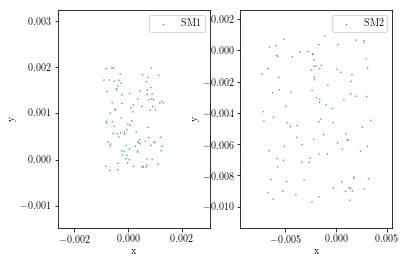

0 time: 0.248978853225708, Power: 2.144977533521579e-13
0
avg: 2.144977533521579e-13%, max: 8.615840520251046e-13%
(x1,y1,x2,y2): (6.295056226344613e-05,0.0014332263234508162,-0.0021132239510479427,-0.0018847959034208025)


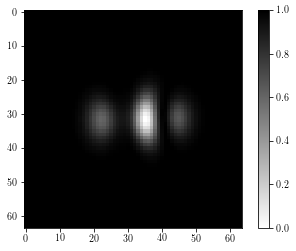

##########Range:  2.2135943621178655  x waist


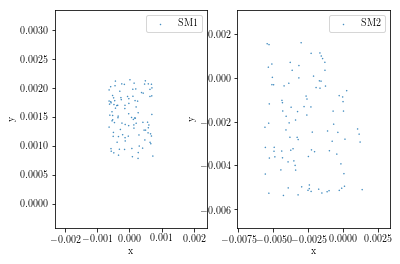

0 time: 9.518410444259644, Power: 3.43749197385288e-08
0
avg: 3.43749197385288e-08%, max: 1.390627021244925e-07%
(x1,y1,x2,y2): (-2.635337156499261e-05,0.0013464038961217934,-4.1173499431170716e-05,-0.0008659143054553771)


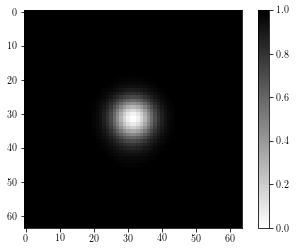

##########Range:  1.4000000000000001  x waist


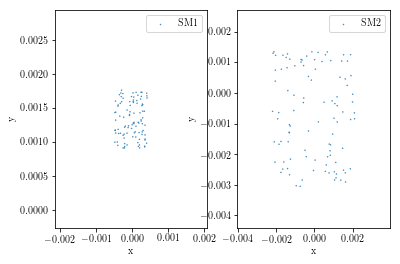

1 time: 19.16551947593689, Power: 3.751479917342027e-07
1
avg: 3.751479917342027e-07%, max: 1.5147632648099484e-06%
(x1,y1,x2,y2): (-0.00026596742817075697,0.0010298837470390817,-0.002237339931000857,-0.00038498010372885866)


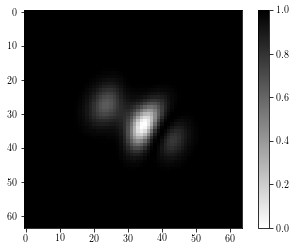

##########Range:  0.8854377448471463  x waist


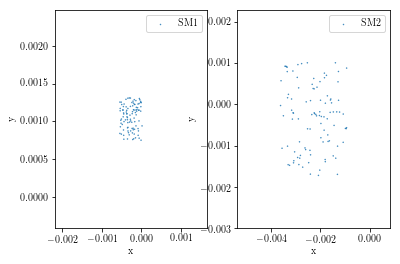

3 time: 29.353909969329834, Power: 8.256337729730132e-07
3
avg: 8.256337729730132e-07%, max: 3.2766255330158877e-06%
(x1,y1,x2,y2): (-0.0004379260932598886,0.001110611522190681,-0.0012343680521672315,-0.0021264992149147895)


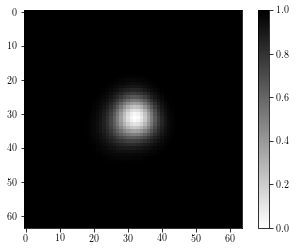

6 time: 29.801521062850952, Power: 5.272405891361746e-05
6
avg: 5.272405891361746e-05%, max: 0.00023289270471548235%
(x1,y1,x2,y2): (-0.00034994259190118703,0.0007506587279166548,-0.0018566885963248723,-0.003046241865362681)


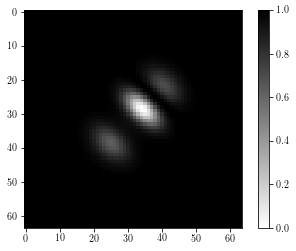

##########Range:  0.56  x waist


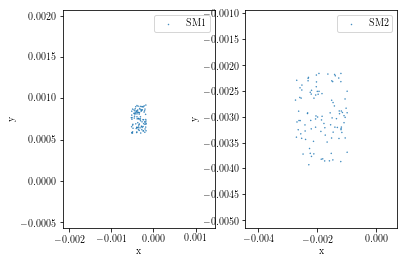

0 time: 38.6935613155365, Power: 0.0038338012886726513
0
avg: 0.0038338012886726513%, max: 0.01734701035752645%
(x1,y1,x2,y2): (-0.00030319065418733603,0.0005787502556961606,-0.0018297977084714002,-0.002554392279880142)


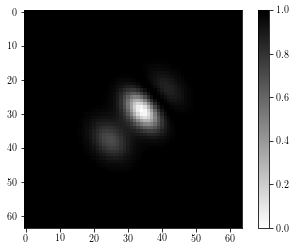

1 time: 38.93177676200867, Power: 0.4760617698855603
1
avg: 0.4760617698855603%, max: 1.8937737361366171%
(x1,y1,x2,y2): (-0.00029080358467421336,0.0006358090354585868,-0.0011632541380322404,-0.0018309990693020888)


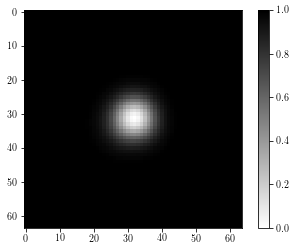

14 time: 40.377076864242554, Power: 1.8346934965220247
14
avg: 1.8346934965220247%, max: 7.176313705729543%
(x1,y1,x2,y2): (-0.0001998018489137088,0.00040006815201847784,-0.0014463247799631732,-0.000942976266119308)


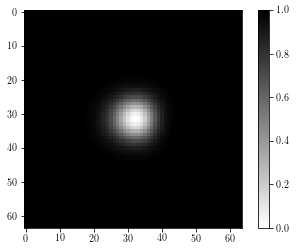

15 time: 40.61429309844971, Power: 1.867116173801218
15
avg: 1.867116173801218%, max: 7.250612949356536%
(x1,y1,x2,y2): (-9.474168878763939e-05,0.0003072855232116158,-0.0014355080843210168,-0.0009593105423235833)


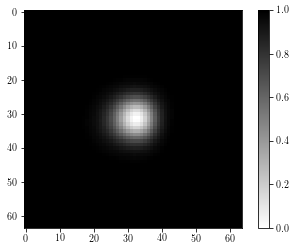

##########Range:  0.35417509793885854  x waist


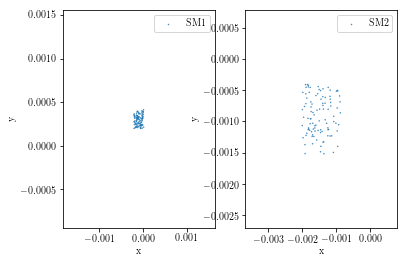

5 time: 49.175363302230835, Power: 2.0245949738180706
5
avg: 2.0245949738180706%, max: 7.909654011861109%
(x1,y1,x2,y2): (-0.0002721318658821546,0.00012378853928132001,-0.0016500296779690567,0.00016537493268630886)


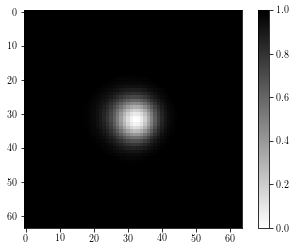

6 time: 49.414751291275024, Power: 6.417063909792119
6
avg: 6.417063909792119%, max: 25.38577802267021%
(x1,y1,x2,y2): (-0.0002734251150648113,3.516146140544979e-05,-0.0012077850437683239,0.0006079029178094481)


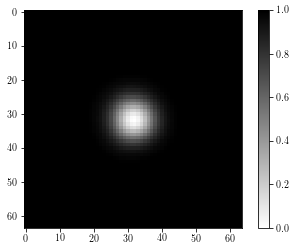

##########Range:  0.22400000000000003  x waist


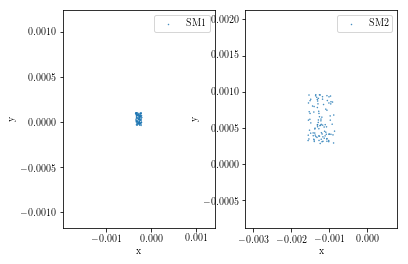

0 time: 58.65353274345398, Power: 10.898940475689505
0
avg: 10.898940475689505%, max: 43.34753575881863%
(x1,y1,x2,y2): (-0.0002563539662717002,9.891012280518346e-06,-0.0010035876479771446,0.00041395291792930004)


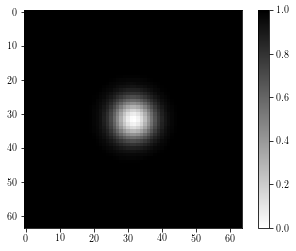

2 time: 59.008496046066284, Power: 11.635288674441444
2
avg: 11.635288674441444%, max: 46.05019535921726%
(x1,y1,x2,y2): (-0.0002126141375087836,5.467196328083585e-06,-0.0010784355533518602,0.00013907578535270432)


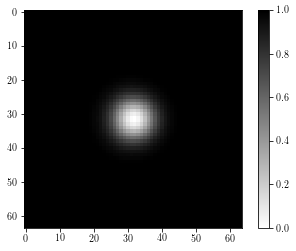

3 time: 59.247398853302, Power: 13.928552435501235
3
avg: 13.928552435501235%, max: 55.702660185136175%
(x1,y1,x2,y2): (-0.00024157446925057328,-3.993326086718107e-05,-0.0008259807821577787,0.00036415875818336153)


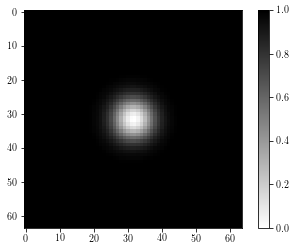

6 time: 59.68052339553833, Power: 14.317404444902527
6
avg: 14.317404444902527%, max: 57.3321458100157%
(x1,y1,x2,y2): (-0.0002504432897501968,-3.113957125294244e-05,-0.0008069703900669775,-1.0337627783584306e-05)


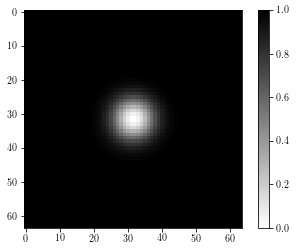

##########Range:  0.1416700391755434  x waist


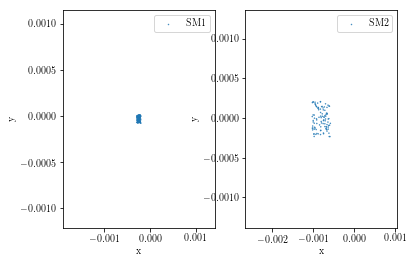

0 time: 68.5843768119812, Power: 16.700477457019385
0
avg: 16.700477457019385%, max: 66.96753470738223%
(x1,y1,x2,y2): (-0.00020846115785351632,-1.9033519478889726e-06,-0.0007039240262234963,-1.2290902945821544e-05)


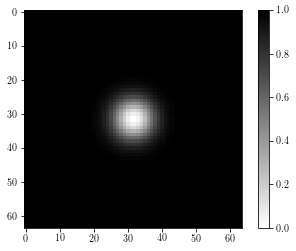

1 time: 68.82430768013, Power: 18.96245569453965
1
avg: 18.96245569453965%, max: 76.57708765651098%
(x1,y1,x2,y2): (-0.00017781759690940454,1.2443412020191037e-05,-0.0004820182272984086,-6.965241018499795e-05)


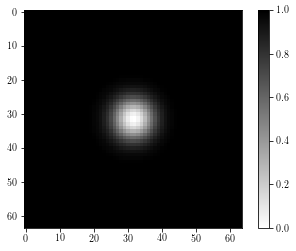

2 time: 69.07879114151001, Power: 19.66399510842559
2
avg: 19.66399510842559%, max: 79.21939429685496%
(x1,y1,x2,y2): (-0.00015375622353887188,4.793685354871839e-05,-0.0004978746371787541,-3.588378928066494e-05)


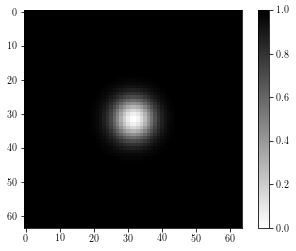

##########Range:  0.08960000000000001  x waist


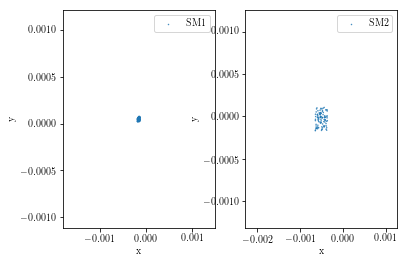

1 time: 78.59780693054199, Power: 19.664497900277784
1
avg: 19.664497900277784%, max: 78.99417269576334%
(x1,y1,x2,y2): (-0.00014154249859390792,3.1058609402811775e-05,-0.0005614581798731766,-7.359069007822151e-05)


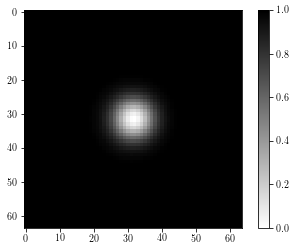

6 time: 79.21230578422546, Power: 19.745333892445704
6
avg: 19.745333892445704%, max: 79.86038405627728%
(x1,y1,x2,y2): (-0.0001621751370280056,2.622506602911924e-05,-0.00040897251431521207,-0.0001298581384553508)


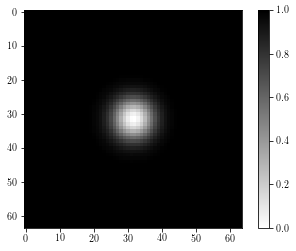

53 time: 83.64534425735474, Power: 19.8351111066458
53
avg: 19.8351111066458%, max: 79.89528743375847%
(x1,y1,x2,y2): (-3.335044881841512e-06,7.008741855148334e-05,-0.000290659425672219,0.00019702507891003305)


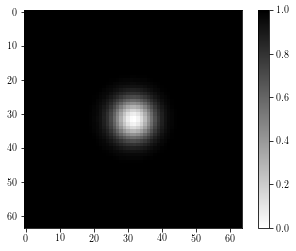

54 time: 83.88793969154358, Power: 21.700649699909082
54
avg: 21.700649699909082%, max: 87.49153509514888%
(x1,y1,x2,y2): (-6.008100541831026e-06,5.789652906295719e-05,-0.00015801593397981911,0.000216112221422416)


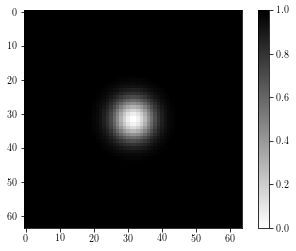

57 time: 84.32077956199646, Power: 21.765068404822305
57
avg: 21.765068404822305%, max: 87.6902590040611%
(x1,y1,x2,y2): (-1.4864336866968323e-06,4.2222811815391064e-06,-0.0002880503031837991,0.00014299433619333507)


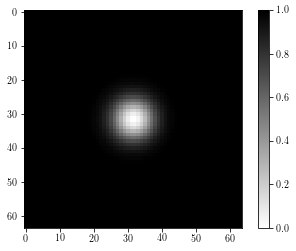

##########Range:  0.05666801567021737  x waist


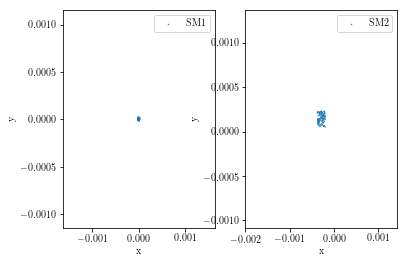

In [49]:
# waist size in m
waist = 140e-6
# range of movement of the waist center at the waist location in the units of waist size
Range = 3.5
# cumulative distance of waist from SM1 in m
d1 = 0.35+0.0884
# cumulative distance of waist from SM2 in m
d2 = 0.0884
dist_to_w = {'SM1': d1, 'SM2': d2}
# Scale for initial random misalignment in the units of waist size
a = 3.
samples = 100
# after each iteration, range shrinks by
shrink_factor = 2. / samples ** 0.25  # make sure it is < 1.

np.random.seed(198)

beam_status = {'SM1': {'x': 0., 'y': 0.}, 'SM2': {'x': 0., 'y': 0.}}
t1 = time.time()
checkpoints = []
# random alignment initially
for sm in beam_status.keys():
    for direction in beam_status[sm].keys():
        # give angle in deg
        beam_status[sm][direction] = (2. * a * np.random.random() - a)
        beam_status[sm][direction] *= waist / dist_to_w[sm]

print(beam_status)
R_Max = 0.
# plot sampling
# plt.ion()
# plt.figure(figsize=(15,8))
# plt.show()
for j in range(10):
    print("##########Range: ", Range, " x waist")
    beam_status, IMG, R_Max = scan_range(samples, Range, deepcopy(beam_status), \
                                         R_Max, scatter_plot=True, make_im=True, disp_each_step=False)
    Range *= shrink_factor

In [ ]:
1e-2 * (0.35+0.0884) / 3.14 * 180

In [ ]:
from copy import deepcopy
def testfun(b1):
    b1['test'] = 2
    print(b1)
    
b = {'hi':1}
testfun(deepcopy(b))
b

In [ ]:
Range = 1e-2
a = 5e-3
samples = 50

np.random.seed(197)
def Reward(b1x, b2x, b1y, b2y):
    # find reward fn
    base.SM1.xbeta = b1x
    base.SM1.ybeta = b1y
    base.SM2.xbeta = b2x
    base.SM2.ybeta = b2y
    out = base.run()
    Img = np.array(out['CCD'])
    R_fn = Img.sum()/n_pixl**2/1.95749
    return R_fn, b1x, b1y, b2x, b2y, Img

def out_vals(R_fn, b1x, b1y, b2x, b2y, Img):
    print("avg: {}%, max: {}%\n(x1,y1,x2,y2): ({},{},{},{})".format(R_fn, \
                                                                  Img.max()/71.90626, b1x, b1y, b2x, b2y))
    Img /= np.max(Img)
    Img = 1. - Img
    plt.imshow(Img[::-1], cmap=cm.binary)
    plt.colorbar()
    plt.show()
    
def sample_d(samples, Range):
    dx1 = np.random.random(100*samples) * 2*Range - Range
    dx2 = np.random.random(100*samples) * 2*Range - Range
    dy1 = np.random.random(100*samples) * 2*Range - Range
    dy2 = np.random.random(100*samples) * 2*Range - Range
    i_acc = np.where((dx1**2. + dx2**2. + dy1**2. + dy2**2.) < Range**2.)
    dx1 = dx1[i_acc][:samples]
    dx2 = dx2[i_acc][:samples]
    dy1 = dy1[i_acc][:samples]
    dy2 = dy2[i_acc][:samples]
    return dx1, dx2, dy1, dy2

t_c = 0.
t1 = time.time()
for j in range(10):
    print(Range)
    Range /= 2.
    print(Range)
    if j == 0:
        b1x, b2x, b1y, b2y = (np.random.random()*a, np.random.random()*a, \
                      np.random.random()*a, np.random.random()*a)
    else:
        b1x, b2x, b1y, b2y = (b1x+dx1[i_max], b2x+dx2[i_max], b1y+dy1[i_max], b2y+dy2[i_max])
    dx1, dx2, dy1, dy2 = sample_d(samples, Range)
    for i in range(samples):
        if i == 0:
            R_old = 0.
            R_max = 0.
        else:
            R_old = R_new
        t3 = time.time()
        R_new, B1x, B1y, B2x, B2y, IMG = Reward(b1x+dx1[i], b2x+dx2[i], b1y+dy1[i], b2y+dy2[i])
        t4 = time.time()
        t_c += (t4 - t3)
        if R_new > R_max: 
            i_max = i
            R_max = R_new
            out_vals(R_new, B1x, B1y, B2x, B2y, IMG)
            print(i_max, "Power: {}".format(R_new))
t2 = time.time()
print(t_c, t2-t1)

In [ ]:
57.700743436813354/61.45157051086426

In [ ]:
# Steering mirror misalignments [rad]
# ------------------------------------
a = 1e-3
b1x, b2x, b1y, b2y = (np.random.random()*a, np.random.random()*a, \
                      np.random.random()*a, np.random.random()*a)

xDir = True
yDir = True
i = 0
new_mode = 'HG_4_4'

while True:
    old_mode = new_mode
    # Steering inputs
    base.SM1.xbeta = b1x
    base.SM1.ybeta = b1y
    base.SM2.xbeta = b2x
    base.SM2.ybeta = b2y
    # Running simulation
    out = base.run()
    # Read mode
    new_mode = read_mode(out)[0]
    print(i, new_mode)
    if new_mode == "HG_0_0":
        print("Beam aligned.")
        break
    elif i > 100:
        break
    # check direction
    xDir, yDir = check_direction(old_mode, new_mode, xDir, yDir)
    # decide steering i/p
    b1x, b2x, b1y, b2y = steering_inp(new_mode, xDir, yDir, b1x, b2x, b1y, b2y)
    i += 1

In [ ]:
# base.parse("""
# xaxis CCD x lin -15 15 127
# x2axis CCD y lin -15 15 127
# yaxis abs
# """)

a = 1e-4
nn = 0.
n2 = 0
# b1x, b2x, b1y, b2y = (np.random.random()*a, np.random.random()*a, \
#                       np.random.random()*a, np.random.random()*a)
b1x, b2x, b1y, b2y = (nn*a, n2*a, nn*a, n2*a)
base.SM1.xbeta = b1x
base.SM1.ybeta = b1y
base.SM2.xbeta = b2x
base.SM2.ybeta = b2y

out = base.run()

Img = np.array(out['CCD'])
print("avg: {}%, max: {}%\n(x1,y1,x2,y2): ({},{},{},{})".format(Img.sum()/n_pixl**2/1.95749, \
                                                              Img.max()/71.90626, b1x, b1y, b2x, b2y))
Img /= np.max(Img)
Img = 1. - Img
plt.imshow(Img[::-1], cmap=cm.binary)
plt.colorbar()
plt.show()

In [ ]:
Range

In [ ]:
step = 1e-4
a = 2e-3
lr = 1e-6
tol = 1e-4
# b1x, b2x, b1y, b2y = (np.random.random()*a, np.random.random()*a, \
#                       np.random.random()*a, np.random.random()*a)
b1x, b2x, b1y, b2y = (np.random.random()*a, 0., 0., 0.)
# # In each param
# for param in [b1x, b2x, b1y, b2y]:
updated_step_x1 = step
for i in range(100):
    if i==0:
        R1 = Reward(b1x, b2x, b1y, b2y)
    else:
        R1 = R2
    R2 = Reward(b1x+updated_step_x1, b2x, b1y, b2y)
    if abs(R2 - R1) / R1 < tol:
        print("Breaking: ", abs(R2 - R1) / R1)
        break
    slope_x1 = (R2 - R1) / updated_step_x1
#     if abs(slope_x1) > 5.:
#         slope_x1 *= 5./abs(slope_x1)
#     elif abs(slope_x1) < 1e0:
#         slope_x1 *= 1e0/abs(slope_x1)
    updated_step_x1 = slope_x1 * lr
    b1x += updated_step_x1
    print("slope: {}, R_old: {}, R_new: {}".format(slope_x1, R1, R2))

In [ ]:
import keras.optimizers as ko
adm = ko.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

In [ ]:
def  cal_cost(theta,X,y):
    '''
    
    Calculates the cost for given X and Y. The following shows and example of a single dimensional X
    theta = Vector of thetas 
    X     = Row of X's np.zeros((2,j))
    y     = Actual y's np.zeros((2,1))
    
    where:
        j is the no of features
    '''
    
    m = len(y)
    
    predictions = X.dot(theta)
    cost = (1/2*m) * np.sum(np.square(predictions-y))
    return cost

def stocashtic_gradient_descent(X,y,theta,learning_rate=0.01,iterations=10):
    '''
    X    = Matrix of X with added bias units
    y    = Vector of Y
    theta=Vector of thetas np.random.randn(j,1)
    learning_rate 
    iterations = no of iterations
    
    Returns the final theta vector and array of cost history over no of iterations
    '''
    m = len(y)
    cost_history = np.zeros(iterations)
    
    
    for it in range(iterations):
        cost =0.0
        for i in range(m):
            rand_ind = np.random.randint(0,m)
            X_i = X[rand_ind,:].reshape(1,X.shape[1])
            y_i = y[rand_ind].reshape(1,1)
            prediction = np.dot(X_i,theta)

            theta = theta -(1/m)*learning_rate*( X_i.T.dot((prediction - y_i)))
            cost += cal_cost(theta,X_i,y_i)
        cost_history[it]  = cost
        
    return theta, cost_history

In [ ]:
lr =0.5
n_iter = 50

theta = np.random.randn(2,1)

X_b = np.c_[np.ones((len(X),1)),X]
theta,cost_history = stocashtic_gradient_descent(X_b,y,theta,lr,n_iter)


print('Theta0:          {:0.3f},\nTheta1:          {:0.3f}'.format(theta[0][0],theta[1][0]))
print('Final cost/MSE:  {:0.3f}'.format(cost_history[-1]))

Theta0:          3.619,
Theta1:          3.101
Final cost/MSE:  40.137

In [ ]:
fig,ax = plt.subplots(figsize=(10,8))

ax.set_ylabel('{J(Theta)}',rotation=0)
ax.set_xlabel('{Iterations}')
theta = np.random.randn(2,1)

_=ax.plot(range(n_iter),cost_history,'b.')

## PCA

In [ ]:
from sklearn.decomposition import PCA
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
pca = PCA(n_components=2)
pca.fit(X)

In [ ]:
pca.components_[0]

In [ ]:
plt.scatter(X[:,0], X[:,1])
plt.plot(pca.components_[:,0], pca.components_[:,1])
plt.show()